# LSTM Prediction for the Unemployment rate of California

writen by Duo

## Setting

In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

In [3]:
if (torch.cuda.is_available()):
    device = torch.device("cuda:0")
    print('Training on GPU.')
else:
    device = torch.device("cpu")
    print('No GPU available, training on CPU.')

Training on GPU.


# Tuning Paramaters

In [4]:
INPUT_FEATURES_NUM = 5
OUTPUT_FEATURES_NUM = 1
LEARNING_RATE = 0.01
PREV_LOSS = 1000
MAX_EPOCHS = 2000

## Dataset


In [5]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out = pd.read_csv(loc,**kwargs)
    return out


fname=("Local_Area_Unemployment_Statistics__LAUS_.csv","https://drive.google.com/file/d/1xoDHEKiN-y4QyZNET8SdlVRSsgW_7TLy/view?usp=sharing")
data=getfile(fname)

local file not found; accessing Google Drive


In [6]:
data['Date']= pd.to_datetime(data['Date'])
data['ts'] = data.Date.values.astype(np.int64) # convert datetime to pandas timestamps
data['Employment Rate']=data['Employment ']/data['Labor Force']
data.columns = ['Area Type', 'Area Name', 'Date', 'Year', 'Month',
       'Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)',
       'Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate','ts','Employment Rate']
cat_col = ['Area Type', 'Area Name','Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)']
time_col = ['Date', 'Year', 'Month']
num_col = ['Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate', 'ts', 'Employment Rate']

In [7]:
data.head()

,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate,ts,Employment Rate
0,State,California,1976-01-01,1976,January,N,Final,9672362,8668016,1004346,0.10,189302400000000000,0.90
1,State,California,1976-01-01,1976,January,Y,Final,9774280,8875685,898595,0.09,189302400000000000,0.91
2,County,Los Angeles County,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.10,189302400000000000,0.90
3,County,Los Angeles County,1976-01-01,1976,January,Y,Final,3381856,3081806,300050,0.09,189302400000000000,0.91
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.10,189302400000000000,0.90


In [8]:
data["Area Name"].value_counts()

California                            1122
Los Angeles-Long Beach-Glendale MD    1122
Los Angeles County                    1122
Tuolumne County                        393
Hanford-Corcoran MSA                   393
                                      ... 
Hawaiian Gardens city                  153
Hawthorne city                         153
Hayfork CDP                            153
Hayward city                           153
Lakewood city                          153
Name: Area Name, Length: 1050, dtype: int64

In [9]:
data["Area Name"].unique()

array(['California', 'Los Angeles County',
       'Los Angeles-Long Beach-Glendale MD', ...,
       'Vallejo-Fairfield, CA MSA', 'Visalia-Porterville, CA MSA',
       'Yuba City, CA MSA'], dtype=object)

## Data Processing

In [10]:
def Area_chosen(place = 'California'):
    df = data.loc[(data['Area Name'] == place)]
    df = df.loc[(df['Seasonally Adjusted (Y/N)']=='N')]
    df = df.loc[(df['Status (Preliminary / Final)']=='Final')]
    df = df[['Date', 'Unemployment Rate']]
    df.set_index(["Date"], inplace=True)
    df = df.sort_index(ascending=True)
    order = []
    for i in range(INPUT_FEATURES_NUM + 1):
        j = 'R-' + str(i)
        df[j] = df['Unemployment Rate'].shift(i)
        order.append(j)
    order.reverse()
    df = df.dropna()
    df = df[order]
    return df


In [11]:
city = 'California' # chose your city in california or see the data of all state
df = Area_chosen(city)

S = StandardScaler()
Ss = S.fit_transform(df)
Ss = Ss.astype('float32')

y = Ss[:,-1]
X = np.delete(Ss,-1,axis=1)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle = False)

train_x_tensor = train_x.reshape(-1, 1, INPUT_FEATURES_NUM)  # set batch size to 1
train_y_tensor = train_y.reshape(-1, 1, OUTPUT_FEATURES_NUM)  # set batch size to 1
 
train_x_tensor = torch.from_numpy(train_x_tensor).to(device)
train_y_tensor = torch.from_numpy(train_y_tensor).to(device)

## LSTM Model

In [12]:
class LstmRNN(nn.Module):
    """
        Parameters：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
 
    def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
        super().__init__()
 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)  # utilize the LSTM model in torch.nn
        self.linear1 = nn.Linear(hidden_size, output_size) #
 
    def forward(self, _x):
        x, _ = self.lstm(_x) # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s * b, h)
        x = self.linear1(x)
        x = x.view(s, b, -1)
        return x



In [13]:
def lossFunction(evaluation = 'MSE'):
    if evaluation == 'Huber':
        criterion = nn.HuberLoss()
    elif evaluation == 'SmoothL1':
        criterion = nn.SmoothL1Loss()
    else:
        criterion = nn.MSELoss()
    return criterion

#loss_function = lossFunction(evaluation = 'MSE')

In [14]:
def train(loss_function, lr = LEARNING_RATE, prev_loss = PREV_LOSS, max_epochs = MAX_EPOCHS):
    
    lstm_model = LstmRNN(INPUT_FEATURES_NUM, 20, output_size=OUTPUT_FEATURES_NUM, num_layers=1).to(device)  # 20 hidden units
    
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
 
    prev_loss = PREV_LOSS
    max_epochs = MAX_EPOCHS    
    
    lstm_model.train()
    for epoch in range(max_epochs):
        output = lstm_model(train_x_tensor)
        loss = loss_function(output, train_y_tensor)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        if loss < prev_loss:
            #torch.save(lstm_model.state_dict(), f'lstm_model_{city}.pt')  # save model parameters to files
            prev_loss = loss
 
        if loss.item() < 1e-4:
            print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch + 1, max_epochs, loss.item()))
            print("The loss value is reached")
            break
        elif (epoch + 1) % 100 == 0:
            print('Epoch: [{}/{}], Loss:{:.5f}'.format(epoch + 1, max_epochs, loss.item()))
    
    return lstm_model

In [15]:
def evaluation(loss_function, lstm_model):

    pred_y_for_train = lstm_model(train_x_tensor).to(device)
    pred_y_for_train = pred_y_for_train.cpu().view(-1, OUTPUT_FEATURES_NUM).data.numpy()

    lstm_model = lstm_model.eval()  # switch to testing model
 
    test_x_tensor = test_x.reshape(-1, 1,
                                   INPUT_FEATURES_NUM)
    test_x_tensor = torch.from_numpy(test_x_tensor)  
    test_x_tensor = test_x_tensor.to(device)
 
    pred_y_for_test = lstm_model(test_x_tensor)
    pred_y_for_test = pred_y_for_test.cpu().view(-1, OUTPUT_FEATURES_NUM).data.numpy()

    loss = loss_function(torch.from_numpy(pred_y_for_test), torch.from_numpy(test_y))
    print("test loss:", loss.item())
    return pred_y_for_train, pred_y_for_test

## Model Viz

In [16]:
def viz(evaluation, train_y = train_y):
    pred_y_for_train, pred_y_for_test = evaluation
    plt.figure()
    plt.plot(range(len(train_y)), train_y, 'b', label='y_trn')
    plt.plot(range(len(train_y)), pred_y_for_train, 'y--', label='pre_trn')
 
    plt.plot(range(len(train_y),len(train_y)+len(test_y)), test_y, 'k', label='y_tst')
    plt.plot(range(len(train_y),len(train_y)+len(test_y)), pred_y_for_test, 'm--', label='pre_tst')
 
    plt.xlabel('t')
    plt.ylabel('Rate')
    plt.show()


## Effectiveness Comparison of Multiple Loss Functions


Epoch: [100/2000], Loss:0.03121
Epoch: [200/2000], Loss:0.02411
Epoch: [300/2000], Loss:0.01155
Epoch: [400/2000], Loss:0.00565
Epoch: [500/2000], Loss:0.00428
Epoch: [600/2000], Loss:0.00375
Epoch: [700/2000], Loss:0.00300
Epoch: [800/2000], Loss:0.00504
Epoch: [900/2000], Loss:0.00370
Epoch: [1000/2000], Loss:0.00274
Epoch: [1100/2000], Loss:0.00215
Epoch: [1200/2000], Loss:0.00174
Epoch: [1300/2000], Loss:0.00141
Epoch: [1400/2000], Loss:0.00113
Epoch: [1500/2000], Loss:0.00093
Epoch: [1600/2000], Loss:0.00085
Epoch: [1700/2000], Loss:0.00078
Epoch: [1800/2000], Loss:0.00055
Epoch: [1900/2000], Loss:0.00043
Epoch: [2000/2000], Loss:0.00037
test loss: 2.1537704467773438


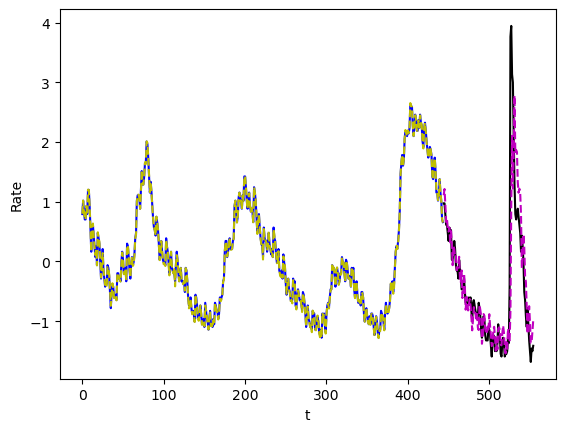

In [17]:
loss_function = lossFunction(evaluation = 'MSE')
t = train(loss_function)
e = evaluation(loss_function, t)
viz(e)

Epoch: [100/2000], Loss:0.01422
Epoch: [200/2000], Loss:0.01236
Epoch: [300/2000], Loss:0.00850
Epoch: [400/2000], Loss:0.00880
Epoch: [500/2000], Loss:0.00287
Epoch: [600/2000], Loss:0.00778
Epoch: [700/2000], Loss:0.00346
Epoch: [800/2000], Loss:0.00201
Epoch: [900/2000], Loss:0.00142
Epoch: [1000/2000], Loss:0.00114
Epoch: [1100/2000], Loss:0.00124
Epoch: [1200/2000], Loss:0.00081
Epoch: [1300/2000], Loss:0.00076
Epoch: [1400/2000], Loss:0.00062
Epoch: [1500/2000], Loss:0.00053
Epoch: [1600/2000], Loss:0.00056
Epoch: [1700/2000], Loss:0.00066
Epoch: [1800/2000], Loss:0.00041
Epoch: [1900/2000], Loss:0.00034
Epoch: [2000/2000], Loss:0.00031
test loss: 0.7466513514518738


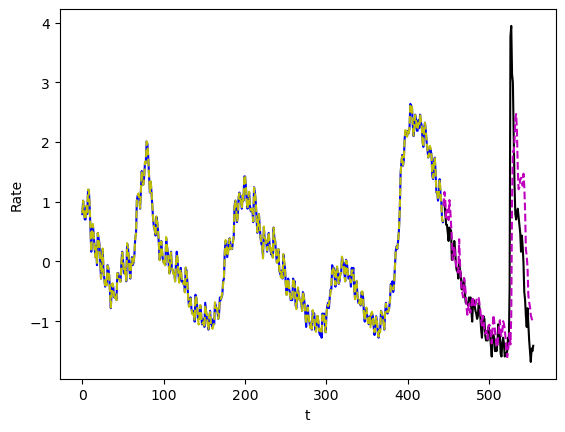

In [18]:
loss_function = lossFunction(evaluation = 'Huber')
t = train(loss_function)
e = evaluation(loss_function, t)
viz(e)

Epoch: [100/2000], Loss:0.01474
Epoch: [200/2000], Loss:0.01064
Epoch: [300/2000], Loss:0.00936
Epoch: [400/2000], Loss:0.00430
Epoch: [500/2000], Loss:0.00314
Epoch: [600/2000], Loss:0.00223
Epoch: [700/2000], Loss:0.00283
Epoch: [800/2000], Loss:0.00148
Epoch: [900/2000], Loss:0.00123
Epoch: [1000/2000], Loss:0.00110
Epoch: [1100/2000], Loss:0.00084
Epoch: [1200/2000], Loss:0.00074
Epoch: [1300/2000], Loss:0.00059
Epoch: [1400/2000], Loss:0.00054
Epoch: [1500/2000], Loss:0.00045
Epoch: [1600/2000], Loss:0.00041
Epoch: [1700/2000], Loss:0.00054
Epoch: [1800/2000], Loss:0.00026
Epoch: [1900/2000], Loss:0.00027
Epoch: [2000/2000], Loss:0.00021
test loss: 0.6885759830474854


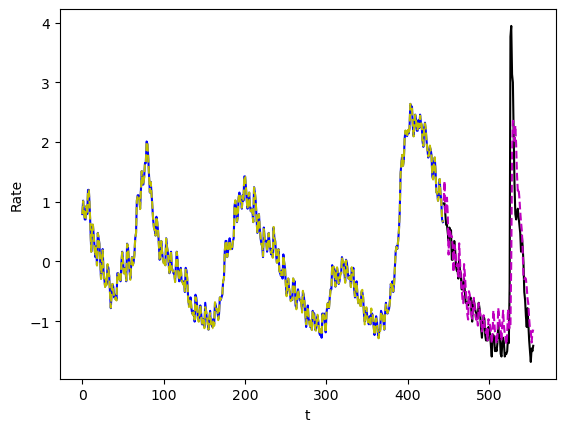

In [19]:
loss_function = lossFunction(evaluation = 'SmoothL1')
t = train(loss_function)
e = evaluation(loss_function, t)
viz(e)